In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 10 09:58:01 2021

@author: gurasog
"""

def make_data(raw,window,bias,states):

    
    time_samples=len(raw['Fz'][0][0])
    
    list_of_states=[]
    train_data_list=[]
    
    for c in np.arange(0,(time_samples-(window-bias)),bias):

            sum_of_states=sum(states[c:c+window])
            
            if (sum_of_states%window)==0 and (sum_of_states/window)==states[c]:

                list_of_states.append(states[c])

                train_data_list.append(np.arange(c,(c+window)))



    return list_of_states, train_data_list



def conf_plot(labels_test,y_pred,states):
    import seaborn
    
    cm=confusion_matrix( labels_test,y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in states],
                      columns = [i for i in states])
    plt.figure(figsize = (10,8))
    ax = sns.heatmap(df_cm, annot=True, fmt="d")
    ax.set_ylim(len(states)+0.5, -0.5)
    
    
def acc_per_class(y_true,y_pred,states):
    cm = confusion_matrix(y_true, y_pred)
    #array([[1, 0, 0],
    #   [1, 0, 0],
    #   [0, 1, 2]])

    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #array([[1.        , 0.        , 0.        ],
    #      [1.        , 0.        , 0.        ],
    #      [0.        , 0.33333333, 0.66666667]])

    #The diagonal entries are the accuracies of each class
    
    for i in range(len(states)):
        print(states[i]+'   '+str(cm.diagonal()[i]))
        
    return #cm.diagonal()
    
        
    

from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import  mne 
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# pyriemann import
from pyriemann.classification import MDM #, TSclassifier
from pyriemann.estimation import Covariances,Shrinkage


# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix




In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP


In [3]:
import pandas as pd

In [4]:

subject = 1

tmin, tmax = -1., 7.
event_id = dict(hands=2, feet=3)
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
raw.rename_channels(lambda x: x.strip('.'))
raw.rename_channels(lambda x: x.replace('Cp','CP'))
raw.rename_channels(lambda x: x.replace('Fc','FC'))
raw.rename_channels(lambda x: x.replace('Af','AF'))
raw.rename_channels(lambda x: x.replace('Ft','FT'))
raw.rename_channels(lambda x: x.replace('Tp','TP'))
raw.rename_channels(lambda x: x.replace('Po','PO'))
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.rename_channels(lambda x: x.strip('.'))
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')



events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)



labels = epochs.events[:, -1] - 2



cv = ShuffleSplit(10, test_size=0.2, random_state=42)

cv = KFold(n_splits=10, random_state=42)
epochs_data_train = 1e6 * epochs.get_data()

cov_data_train = Covariances().transform(epochs_data_train)
cov_data_train= Shrinkage().transform(cov_data_train)
cov_data_train.shape


epochs_train_tmin=1
epochs_train_tmax=2
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
epochs_data_train = 1e6 *epochs_train.get_data()
epochs_data = 1e6 *epochs.get_data()


window=1
step=0.2

sfreq = raw.info['sfreq']
w_length = int(sfreq * window)   # running classifier: window length
w_step = int(sfreq * 0.2)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)


for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    

    cov_data_train = Covariances().transform(epochs_data_train[train_idx])
    cov_data_train= Shrinkage().transform(cov_data_train)
    
    x_train=cov_data_train
    
    mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
    # fit classifier
    mdm.fit(x_train,y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    
    for k in range(len(w_start)):
        n=w_start[k]
        
        cov_data_test = Covariances().transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        cov_data_test= Shrinkage().transform(cov_data_test)
        y_pred=mdm.predict(cov_data_test)
        aaaa=accuracy_score(y_pred,y_test)
        
        score_this_window.append(aaaa)

        #one_row=[w_times[k],window,step,'MI_Hands', str(epochs_train_tmin)+' '+str(epochs_train_tmax),lda.score(X_test, y_test)]
        #ind=len(df)
        #df.loc[ind]=one_row

        #print(aaaa)

    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KeyboardInterrupt: 

## Обычный риман 10 испытуемых

In [50]:

for i in range(1,5):


    subject = i
    

    tmin, tmax = -1., 7.
    event_id = dict(hands=2, feet=3)
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    raw.rename_channels(lambda x: x.strip('.'))
    raw.rename_channels(lambda x: x.replace('Cp','CP'))
    raw.rename_channels(lambda x: x.replace('Fc','FC'))
    raw.rename_channels(lambda x: x.replace('Af','AF'))
    raw.rename_channels(lambda x: x.replace('Ft','FT'))
    raw.rename_channels(lambda x: x.replace('Tp','TP'))
    raw.rename_channels(lambda x: x.replace('Po','PO'))
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)
    raw.rename_channels(lambda x: x.strip('.'))
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')



    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)



    labels = epochs.events[:, -1] - 2



    cv = ShuffleSplit(10, test_size=0.2, random_state=42)

    cv = KFold(n_splits=10, random_state=42)
    epochs_data_train = 1e6 * epochs.get_data()

    cov_data_train = Covariances().transform(epochs_data_train)
    cov_data_train= Shrinkage().transform(cov_data_train)
    cov_data_train.shape


    epochs_train_tmin=1
    epochs_train_tmax=5
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    epochs_data_train = 1e6 *epochs_train.get_data()
    epochs_data = 1e6 *epochs.get_data()


    window=1
    step=0.2

    sfreq = raw.info['sfreq']
    w_length = int(sfreq * window)   # running classifier: window length
    w_step = int(sfreq * 0.2)  # running classifier: window step size
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)


    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]



        cov_data_train = Covariances().transform(epochs_data_train[train_idx])
        cov_data_train= Shrinkage().transform(cov_data_train)

        x_train=cov_data_train

        mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
        # fit classifier
        mdm.fit(x_train,y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []

        for k in range(len(w_start)):
            n=w_start[k]

            cov_data_test = Covariances().transform(epochs_data[test_idx][:, :, n:(n + w_length)])
            cov_data_test= Shrinkage().transform(cov_data_test)
            y_pred=mdm.predict(cov_data_test)
            aaaa=accuracy_score(y_pred,y_test)

            score_this_window.append(aaaa)

            #one_row=[w_times[k],window,step,'MI_Hands', str(epochs_train_tmin)+' '+str(epochs_train_tmax),lda.score(X_test, y_test)]
            #ind=len(df)
            #df.loc[ind]=one_row

            #print(aaaa)

        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
    
    np.save('Riemann_results/Riemann_results'+str(i), np.array(scores_windows))



Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [38]:

def make_data(raw,window,bias,states,Fs=160):

    try:
    
        time_samples=len(raw['Fz'][0][0])
    
    except :
        
        time_samples=len(np.arange(0,raw.shape[1]*1/160,1/160))
        
        
    list_of_states=[]
    train_data_list=[]

    for c in np.arange(0,(time_samples-(window-bias)),bias):

            sum_of_states=sum(states[c:c+window])

            if (sum_of_states%window)==0 and (sum_of_states/window)==states[c]:

                list_of_states.append(states[c])

                train_data_list.append(np.arange(c,(c+window)))


    return list_of_states, train_data_list


### Риман 10 испытуемых, нарезанный на кусочки

In [52]:
df=pd.DataFrame(columns=['time','window','bias','tasks','csp_len','subject','validation_i','acc'])
windows=[1]#[0.5,1,2]
bias=[0.2]#[0.05,0.1,0.25,0.5]
tasks=[ 
    
    #[3, 7, 11], #Motor execution: left vs right hand
    #[4, 8, 12], #Motor imagery: left vs right hand
    #[5, 9, 13], #Motor execution: hands vs feet
    [6, 10, 14], #Motor imagery: hands vs feet

]

tain_ranges=[
    
    #[1,2],
    [1,5],
    #[1,7],
    #[0,8],
    
]



for tr in tain_ranges:

    for t in tasks:

        for w in windows:

            for b in bias:

                for subj in range(1,5):


                    subject = subj

                    #tmin, tmax = 0., 8.
                    tmin, tmax = -1, 7
                    
                    event_id = dict(hands=2, feet=3)

                    runs = t


                    raw_fnames = eegbci.load_data(subject, runs)
                    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
                    raw.rename_channels(lambda x: x.strip('.'))
                    raw.rename_channels(lambda x: x.replace('Cp','CP'))
                    raw.rename_channels(lambda x: x.replace('Fc','FC'))
                    raw.rename_channels(lambda x: x.replace('Af','AF'))
                    raw.rename_channels(lambda x: x.replace('Ft','FT'))
                    raw.rename_channels(lambda x: x.replace('Tp','TP'))
                    raw.rename_channels(lambda x: x.replace('Po','PO'))


                    montage = make_standard_montage('standard_1005')
                    raw.set_montage(montage)

                    raw.rename_channels(lambda x: x.strip('.'))


                    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

                    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

                    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       exclude='bads')



                    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                                    baseline=None, preload=True)
                    
                    

                    train_idx_s=[np.arange(10,len(epochs)),  np.concatenate([np.arange(0,10),np.arange(20,len(epochs))]),  np.concatenate([np.arange(0,20),np.arange(30,len(epochs))])  ,np.arange(0,len(epochs)-10)]
                    test_idx_s=[np.arange(0,10)           ,  np.arange(10,20)                                           ,  np.arange(20,30)                                             ,np.arange(len(epochs)-10,len(epochs))]

                    
                    train_range=tr
                    epochs_train_tmin=train_range[0]
                    epochs_train_tmax=train_range[1]

                    epochs_train = epochs.copy().crop(tmin=epochs_train_tmin, tmax=epochs_train_tmax)

                    labels = epochs.events[:, -1] - 2

                    scores = []
                    epochs_data = epochs.get_data()
                    epochs_data_train = epochs_train.get_data()


                    window=w
                    step=b

                    sfreq = raw.info['sfreq']
                    w_length = int(sfreq * window)   # running classifier: window length
                    w_step = int(sfreq * step)  # running classifier: window step size
                    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

                    scores_windows = []

                    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
                    
                    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
                    cv_split = cv.split(epochs_data_train)


                    for train_idx, test_idx in cv_split:
                        
                        y_train, y_test = labels[train_idx], labels[test_idx]
                        
                        X_all=[]
                        Y_all=[]
                        
                        for i in range(len(epochs_data_train[train_idx])):
                            list_of_states_i, train_data_list_i=make_data(epochs_data_train[train_idx[i]],320,50,[events[train_idx[i],2]]*epochs_data_train[train_idx[i]].shape[1])
                            #list_of_states=np.concatenate([list_of_states,list_of_states_i])

                            #train_data_list.append(train_data_list_i)
                            #train_data_list=np.concatenate([train_data_list,train_data_list_i])

                            X_=[]

                            for state_i in range(len(list_of_states_i)-1):
                                X_.append(epochs_data_train[train_idx[i]][:,train_data_list_i[state_i]])

                            X_all.append(X_)
                            Y_all.append(list_of_states_i[:-1])
                            
                        X=np.concatenate(X_all)
                        Y=np.concatenate(Y_all)-2
                        
                        cov_data_train = Covariances().transform(np.array(X))
                        cov_data_train= Shrinkage().transform(cov_data_train)

                        x_train=cov_data_train

                        
                        mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
                        # fit classifier
                        mdm.fit(x_train,Y)

                        # running classifier: test classifier on sliding window
                        score_this_window = []
                        for k in range(len(w_start)):
                            n=w_start[k]
                            
                            cov_data_test = Covariances().transform(epochs_data[test_idx][:, :, n:(n + w_length)])
                            cov_data_test= Shrinkage().transform(cov_data_test)
                            y_pred=mdm.predict(cov_data_test)
                            aaaa=accuracy_score(y_pred,y_test)

                            score_this_window.append(aaaa)

                            #one_row=[w_times[k],window,step,str(runs), str(epochs_train_tmin)+' '+str(epochs_train_tmax),subj,tr_ind,aaaa]
                            #ind=len(df)
                            #df.loc[ind]=one_row



                        scores_windows.append(score_this_window)
                        
                    np.save('Riemann_results/Riemann_results'+str(subject), np.array(scores_windows))
                        
#df.to_pickle('Riemann_Dataframe_2_4.pkl')                        

Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

In [45]:
cov_data_train.shape

(192, 64, 64)

In [40]:
import pandas as pd

In [73]:
df

,time,window,bias,tasks,csp_len,subject,acc,time_category
0,0.25,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0.2
1,0.30,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0.3
2,0.35,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0.3
3,0.40,0.5,0.05,"[3, 7, 11]",1 2,1,0.5,0.4
4,0.45,0.5,0.05,"[3, 7, 11]",1 2,1,0.6,0.5
...,...,...,...,...,...,...,...,...
191995,5.00,2.0,0.50,"[6, 10, 14]",0 8,4,0.5,3.5
191996,5.50,2.0,0.50,"[6, 10, 14]",0 8,4,0.5,3.5
191997,6.00,2.0,0.50,"[6, 10, 14]",0 8,4,0.4,3.5
191998,6.50,2.0,0.50,"[6, 10, 14]",0 8,4,0.5,3.5


In [ ]:
np.arange(10,15)
np.arange(35,39)

In [100]:
df=pd.DataFrame(columns=['time','window','bias','tasks','csp_len','subject','acc'])
windows=[0.5,1,2]
bias=[0.05,0.1,0.25,0.5]
tasks=[ 
    
    [3, 7, 11], #Motor execution: left vs right hand
    [4, 8, 12], #Motor imagery: left vs right hand
    [5, 9, 13], #Motor execution: hands vs feet
    [6, 10, 14], #Motor imagery: hands vs feet

]

tain_ranges=[
    
    [1,2],
    [1,5],
    [1,7],
    [0,8],
    
]



for tr in tain_ranges:

    for t in tasks:

        for w in windows:

            for b in bias:

                for i in range(10,15):


                    subject = i

                    tmin, tmax = 0., 8.
                    
                    event_id = dict(hands=2, feet=3)

                    runs = t


                    raw_fnames = eegbci.load_data(subject, runs)
                    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
                    raw.rename_channels(lambda x: x.strip('.'))
                    raw.rename_channels(lambda x: x.replace('Cp','CP'))
                    raw.rename_channels(lambda x: x.replace('Fc','FC'))
                    raw.rename_channels(lambda x: x.replace('Af','AF'))
                    raw.rename_channels(lambda x: x.replace('Ft','FT'))
                    raw.rename_channels(lambda x: x.replace('Tp','TP'))
                    raw.rename_channels(lambda x: x.replace('Po','PO'))


                    montage = make_standard_montage('standard_1005')
                    raw.set_montage(montage)

                    raw.rename_channels(lambda x: x.strip('.'))


                    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

                    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

                    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       exclude='bads')



                    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                                    baseline=None, preload=True)

                    train_idx_s=[np.arange(10,len(epochs)),  np.concatenate([np.arange(0,10),np.arange(20,len(epochs))]),  np.concatenate([np.arange(0,20),np.arange(30,len(epochs))])  ,np.arange(0,len(epochs)-10)]
                    test_idx_s=[np.arange(0,10)           ,  np.arange(10,20)                                           ,  np.arange(20,30)                                             ,np.arange(len(epochs)-10,len(epochs))]

                    
                    train_range=tr
                    epochs_train_tmin=train_range[0]
                    epochs_train_tmax=train_range[1]

                    epochs_train = epochs.copy().crop(tmin=epochs_train_tmin, tmax=epochs_train_tmax)

                    labels = epochs.events[:, -1] - 2

                    scores = []
                    epochs_data = epochs.get_data()
                    epochs_data_train = epochs_train.get_data()


                    window=w
                    step=b

                    sfreq = raw.info['sfreq']
                    w_length = int(sfreq * window)   # running classifier: window length
                    w_step = int(sfreq * step)  # running classifier: window step size
                    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

                    scores_windows = []

                    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
                    
                    for tr_ind in range(len(train_idx_s)):

                        train_idx=train_idx_s[tr_ind]
                        test_idx=test_idx_s[tr_ind]
                        
                        y_train, y_test = labels[train_idx], labels[test_idx]
                        
                        cov_data_train = Covariances().transform(epochs_data_train[train_idx])
                        cov_data_train= Shrinkage().transform(cov_data_train)

                        x_train=cov_data_train

                        
                        mdm = MDM(metric=dict(mean='riemann', distance='riemann'))
                        # fit classifier
                        mdm.fit(x_train,y_train)

                        # running classifier: test classifier on sliding window
                        score_this_window = []
                        for k in range(len(w_start)):
                            n=w_start[k]
                            cov_data_test = Covariances().transform(epochs_data[test_idx][:, :, n:(n + w_length)])
                            cov_data_test= Shrinkage().transform(cov_data_test)
                            y_pred=mdm.predict(cov_data_test)
                            aaaa=accuracy_score(y_pred,y_test)

                            score_this_window.append(aaaa)

                            one_row=[w_times[k],window,step,str(runs), str(epochs_train_tmin)+' '+str(epochs_train_tmax),i,aaaa]
                            ind=len(df)
                            df.loc[ind]=one_row



                        scores_windows.append(score_this_window)
                    
                    np.save('Riemann_results/Riemann_results'+str(i), np.array(scores_windows))
                        
                        
df.to_pickle('Riemann_Dataframe_long_epochs_10_14.pkl')                        

Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/amplifier/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

In [102]:
scores_windows

[[0.6], [0.7], [0.8], [0.6]]

In [103]:
w_start

array([0])

In [5]:
df_1=pd.read_pickle('Dataframe_for_Riemann/Riemann_Dataframe_long_epochs_1_4.pkl')
df_2=pd.read_pickle('Dataframe_for_Riemann/Riemann_Dataframe_long_epochs_5_9.pkl')
df_3=pd.read_pickle('Dataframe_for_Riemann/Riemann_Dataframe_long_epochs_15_19.pkl')
df_4=pd.read_pickle('Dataframe_for_Riemann/Riemann_Dataframe_long_epochs_20_29.pkl')
df_5=pd.read_pickle('Dataframe_for_Riemann/Riemann_Dataframe_long_epochs_30_34.pkl')


df_all=pd.concat([df_1,df_2,df_3,df_4,df_5])

In [5]:
df_all

,time,window,bias,tasks,csp_len,subject,acc
0,0.25,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
1,0.30,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
2,0.35,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
3,0.40,0.5,0.05,"[3, 7, 11]",1 2,1,0.5
4,0.45,0.5,0.05,"[3, 7, 11]",1 2,1,0.6
...,...,...,...,...,...,...,...
239995,5.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.8
239996,5.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7
239997,6.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.7
239998,6.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7


# Стат анализ

In [6]:
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from statsmodels.stats.multitest import multipletests


In [7]:
df_for_stat_test=df_all.copy()


In [8]:
df_for_stat_test=df_for_stat_test[df_for_stat_test['time']>0]

In [9]:
def round_value(val):
    
    if val>0 and val<=2.25:
        return '0-2'
    
    elif val>2.25 and val<=4:
        return '2-4'
    
    elif val>4 and val<=5.75:
        return '4-6'
    
    elif val>5.75 and val<=8:
        return '6-8'
    
    
    

### Анализ TIME

In [10]:
df_for_stat_test['time_category']=df_for_stat_test.apply(lambda x: round_value(x[0]), axis=1)

In [93]:
df_for_stat_test=df_for_stat_test[['window', 'bias', 'tasks', 'csp_len', 'subject', 'acc','time_category']]
df_for_stat_test

,window,bias,tasks,csp_len,subject,acc,time_category
0,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
1,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
2,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
3,0.5,0.05,"[3, 7, 11]",1 2,1,0.5,0-2
4,0.5,0.05,"[3, 7, 11]",1 2,1,0.6,0-2
...,...,...,...,...,...,...,...
431995,2.0,0.50,"[6, 10, 14]",0 8,28,0.7,4-6
431996,2.0,0.50,"[6, 10, 14]",0 8,28,0.7,4-6
431997,2.0,0.50,"[6, 10, 14]",0 8,28,0.5,6-8
431998,2.0,0.50,"[6, 10, 14]",0 8,28,0.3,6-8


In [94]:
aovrm = AnovaRM(df_for_stat_test, 'acc', 'subject', within=['window', 'bias', 'tasks', 'csp_len', 'time_category'],aggregate_func='mean')
res = aovrm.fit()

print(res)

MemoryError: Unable to allocate 1.86 GiB for an array with shape (14100, 17664) and data type float64

In [107]:
df_for_stat_test_tc=df_for_stat_test[['time_category','acc','subject']]

aovrm = AnovaRM(df_for_stat_test_tc, 'acc', 'subject', within=['time_category'],aggregate_func='mean')
res = aovrm.fit()

print(res)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
time_category 21.0179 3.0000 81.0000 0.0000



In [108]:
m_comp=pairwise_tukeyhsd(df_for_stat_test['acc'],df_for_stat_test['time_category'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0-2    2-4   0.0013 0.0017  0.0004  0.0021   True
   0-2    4-6  -0.0217  0.001 -0.0226 -0.0208   True
   0-2    6-8    -0.05  0.001 -0.0509 -0.0491   True
   2-4    4-6  -0.0229  0.001 -0.0238  -0.022   True
   2-4    6-8  -0.0513  0.001 -0.0522 -0.0504   True
   4-6    6-8  -0.0283  0.001 -0.0292 -0.0274   True
----------------------------------------------------


In [109]:
df_time_cat=df_for_stat_test[['time_category','acc']]
df_time_cat.groupby(['time_category']).mean()

,acc
time_category,
0-2,0.547401
2-4,0.548652
4-6,0.525721
6-8,0.497397


<AxesSubplot:xlabel='time'>

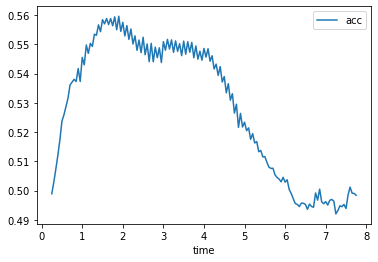

In [110]:
df_all[['time','acc']].groupby('time').mean().plot()

### Anaлиз не Time

In [113]:
df_time_cat=df_all[df_all['time']<=4]

In [114]:
model = ols('acc ~ C(window) + C(bias) + C(tasks) + C(csp_len) +C(subject) +  C(window):C(bias)+ C(window):C(tasks)+ C(window):C(csp_len)+ C(window):C(subject)+  C(bias):C(tasks) +  C(bias):C(csp_len) +   C(bias):C(subject)+ C(tasks):C(csp_len) + C(tasks):C(subject) +C(csp_len):C(subject)+C(window):C(bias):C(tasks)+C(window):C(bias):C(csp_len)+ +C(window):C(bias):C(subject)', data=df_time_cat).fit() 
            
anova_stat=sm.stats.anova_lm(model, typ=2)

In [117]:
anova_stat

,sum_sq,df,F,PR(>F)
C(window),46.350689,2.0,1438.250039,0.000000e+00
C(bias),0.099269,3.0,2.053523,1.040553e-01
C(tasks),569.547423,3.0,11781.940663,0.000000e+00
C(csp_len),120.049033,3.0,2483.393885,0.000000e+00
C(subject),1342.931095,27.0,3086.726574,0.000000e+00
C(window):C(bias),0.020760,6.0,0.214726,9.722957e-01
C(window):C(tasks),29.554641,6.0,305.690986,0.000000e+00
C(window):C(csp_len),2.279123,6.0,23.573532,5.009477e-28
C(window):C(subject),44.541622,54.0,51.189450,0.000000e+00
C(bias):C(tasks),0.110839,9.0,0.764292,6.497545e-01


### Анализ window

In [118]:
df_for_stat_test=df_all[df_all['time']<=4]

In [119]:
m_comp=pairwise_tukeyhsd(df_for_stat_test['acc'],df_for_stat_test['window'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.5    1.0   0.0115 0.001 0.0105 0.0125   True
   0.5    2.0   0.0203 0.001 0.0192 0.0213   True
   1.0    2.0   0.0088 0.001 0.0077 0.0098   True
-------------------------------------------------


In [122]:
df_bias=df_for_stat_test[['window','acc']]
df_bias.groupby(['window']).mean()

,acc
window,
0.5,0.538135
1.0,0.549599
2.0,0.558389


### Анализ bias

In [ ]:
df_for_stat_test=df_all[df_all['time']<=4]

In [123]:

m_comp=pairwise_tukeyhsd(df_for_stat_test['acc'],df_for_stat_test['bias'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  0.05    0.1  -0.0001    0.9 -0.0012  0.001  False
  0.05   0.25  -0.0008 0.5338 -0.0023 0.0007  False
  0.05    0.5   -0.001 0.5159  -0.003 0.0009  False
   0.1   0.25  -0.0007 0.6669 -0.0023 0.0009  False
   0.1    0.5   -0.001 0.6102  -0.003 0.0011  False
  0.25    0.5  -0.0003    0.9 -0.0026  0.002  False
---------------------------------------------------


### Анализ tasks

In [124]:
df_for_stat_test=df_all[df_all['time']<=4]

In [125]:
m_comp=pairwise_tukeyhsd(df_for_stat_test['acc'],df_for_stat_test['tasks'], alpha=0.05)
print(m_comp)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1      group2   meandiff p-adj  lower  upper  reject
-----------------------------------------------------------
[3, 7, 11]  [4, 8, 12]   0.0067 0.001  0.0055  0.008   True
[3, 7, 11]  [5, 9, 13]   0.0739 0.001  0.0726 0.0751   True
[3, 7, 11] [6, 10, 14]   0.0306 0.001  0.0293 0.0319   True
[4, 8, 12]  [5, 9, 13]   0.0671 0.001  0.0658 0.0684   True
[4, 8, 12] [6, 10, 14]   0.0239 0.001  0.0226 0.0251   True
[5, 9, 13] [6, 10, 14]  -0.0433 0.001 -0.0445 -0.042   True
-----------------------------------------------------------


In [126]:
df_bias=df_for_stat_test[['tasks','acc']]
df_bias.groupby(['tasks']).mean()

,acc
tasks,
"[3, 7, 11]",0.520229
"[4, 8, 12]",0.526965
"[5, 9, 13]",0.594085
"[6, 10, 14]",0.550826


### Анализ csp_len

In [130]:
df_for_stat_test=df_all[df_all['time']<=4]

KeyError: "None of [Float64Index([0.25,  0.3, 0.35,  0.4, 0.45,  0.5, 0.55,  0.6, 0.65,  0.7,\n              ...\n               2.5,  3.0,  3.5,  4.0,  4.5,  5.0,  5.5,  6.0,  6.5,  7.0],\n             dtype='float64', length=1344000)] are in the [columns]"

In [131]:
m_comp=pairwise_tukeyhsd(df_for_stat_test['acc'],df_for_stat_test['csp_len'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0 8    1 2   0.0274 0.001  0.0262  0.0287   True
   0 8    1 5   0.0278 0.001  0.0265  0.0291   True
   0 8    1 7   0.0023 0.001   0.001  0.0036   True
   1 2    1 5   0.0004 0.856 -0.0009  0.0017  False
   1 2    1 7  -0.0252 0.001 -0.0265 -0.0239   True
   1 5    1 7  -0.0256 0.001 -0.0269 -0.0243   True
---------------------------------------------------


In [132]:
df_bias=df_for_stat_test[['csp_len','acc']]
df_bias.groupby(['csp_len']).mean()

,acc
csp_len,
0 8,0.526176
1 2,0.532529
1 5,0.533042
1 7,0.528849


In [62]:
from statsmodels.stats.anova import AnovaRM

In [64]:
df[(df['subject']==1) & (df['bias']==0.1)]

,time,window,bias,tasks,csp_len,subject,acc
2416,0.25,0.5,0.1,"[3, 7, 11]",1 2,1,0.7
2417,0.35,0.5,0.1,"[3, 7, 11]",1 2,1,0.7
2418,0.45,0.5,0.1,"[3, 7, 11]",1 2,1,0.6
2419,0.55,0.5,0.1,"[3, 7, 11]",1 2,1,0.6
2420,0.65,0.5,0.1,"[3, 7, 11]",1 2,1,0.5
...,...,...,...,...,...,...,...
190655,6.60,2.0,0.1,"[6, 10, 14]",0 8,1,0.5
190656,6.70,2.0,0.1,"[6, 10, 14]",0 8,1,0.6
190657,6.80,2.0,0.1,"[6, 10, 14]",0 8,1,0.6
190658,6.90,2.0,0.1,"[6, 10, 14]",0 8,1,0.7


In [65]:
df_bias=df[['bias','acc']]
df_bias.groupby(['bias']).mean()

,acc
bias,
0.05,0.552959
0.10,0.552825
0.25,0.552399
0.50,0.552424


In [163]:
df_bias=df[['bias','window','subject','acc','time_category']]

<AxesSubplot:>

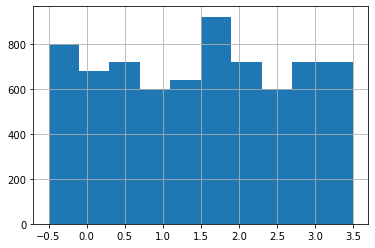

In [170]:
df_bias.time_category.hist()


In [172]:
aovrm = AnovaRM(df_bias, 'acc', 'subject', within=['window','bias','time_category'],aggregate_func='mean')
res = aovrm.fit()

print(res)

ValueError: Data is unbalanced.

In [72]:
df_bias=df[['tasks','acc']]
df_bias.groupby(['tasks']).mean()

,acc
tasks,
"[3, 7, 11]",0.512831
"[4, 8, 12]",0.531383
"[5, 9, 13]",0.628135
"[6, 10, 14]",0.538956


<AxesSubplot:>

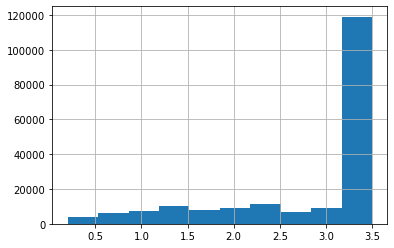

In [68]:
df.time_category.hist()

In [69]:
df_window=df[['window','acc']]
df_window.groupby(['window']).mean()

,acc
window,
0.5,0.538910
1.0,0.553676
2.0,0.569171


In [70]:
df_window=df[['csp_len','acc']]
df_window.groupby(['csp_len']).mean()

,acc
csp_len,
0 8,0.549360
1 2,0.556258
1 5,0.552156
1 7,0.553531


### Анализ окно и задача

In [133]:
df_bias=df_for_stat_test[['tasks','window','acc']]
df_bias.groupby(['tasks','window']).mean()

acc
tasks       window          
[3, 7, 11]  0.5     0.516264
            1.0     0.520970
            2.0     0.524253
[4, 8, 12]  0.5     0.522604
            1.0     0.526604
            2.0     0.532759
[5, 9, 13]  0.5     0.570937
            1.0     0.597409
            2.0     0.618750
[6, 10, 14] 0.5     0.542734
            1.0     0.553412
            2.0     0.557795

### Анализ тренировочное окно и окно 

In [134]:
df_bias=df_for_stat_test[['csp_len','window','acc']]
df_bias.groupby(['csp_len','window']).mean()

acc
csp_len window          
0 8     0.5     0.526292
        1.0     0.534609
        2.0     0.541578
1 2     0.5     0.550375
        1.0     0.563322
        2.0     0.571690
1 5     0.5     0.548182
        1.0     0.564117
        2.0     0.574775
1 7     0.5     0.527690
        1.0     0.536346
        2.0     0.545514

### Анализ тренировочное окно и окно 

In [135]:
df_bias=df_for_stat_test[['csp_len','tasks','acc']]
df_bias.groupby(['csp_len','tasks']).mean()

acc
csp_len tasks                
0 8     [3, 7, 11]   0.511452
        [4, 8, 12]   0.518158
        [5, 9, 13]   0.567899
        [6, 10, 14]  0.537061
1 2     [3, 7, 11]   0.533064
        [4, 8, 12]   0.531191
        [5, 9, 13]   0.619659
        [6, 10, 14]  0.560432
1 5     [3, 7, 11]   0.530921
        [4, 8, 12]   0.542796
        [5, 9, 13]   0.614652
        [6, 10, 14]  0.557516
1 7     [3, 7, 11]   0.505477
        [4, 8, 12]   0.515717
        [5, 9, 13]   0.574131
        [6, 10, 14]  0.548294

# Непараметрические тесты

In [16]:
from scipy.stats import kruskal
from seaborn  import swarmplot
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon,mannwhitneyu
import seaborn as sns
my_dpi=150
import matplotlib
matplotlib.rcParams.update({'font.size': 26})

In [12]:
df_all_cat=df_for_stat_test

In [13]:
df_all_cat

,time,window,bias,tasks,csp_len,subject,acc,time_category
0,0.25,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
1,0.30,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
2,0.35,0.5,0.05,"[3, 7, 11]",1 2,1,0.7,0-2
3,0.40,0.5,0.05,"[3, 7, 11]",1 2,1,0.5,0-2
4,0.45,0.5,0.05,"[3, 7, 11]",1 2,1,0.6,0-2
...,...,...,...,...,...,...,...,...
239995,5.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.8,4-6
239996,5.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7,4-6
239997,6.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.7,6-8
239998,6.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7,6-8


## Task

In [14]:
sns.set()

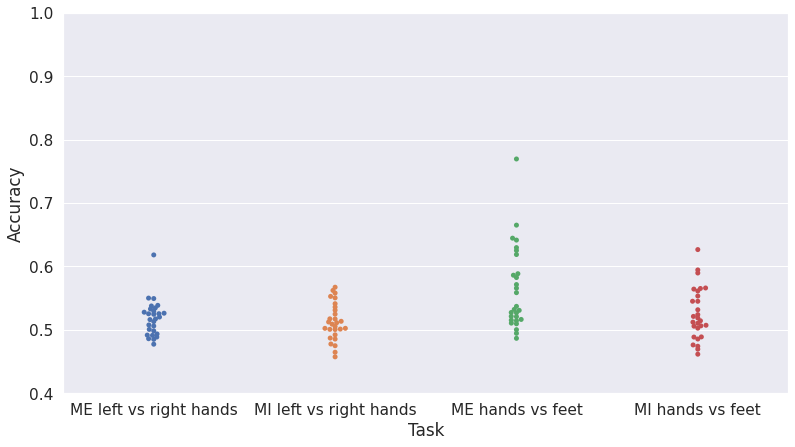

In [18]:
plt.figure(figsize=(13,7))
a=df_all_cat.groupby(['tasks','subject','tasks']).mean('acc')
tasks_column=[a.index.values[i][0] for i in range(len(a))]
sns.set(font_scale=1.4)

tasks_column=np.where(np.array(tasks_column)=='[3, 7, 11]','ME left vs right hands',tasks_column)
tasks_column=np.where(np.array(tasks_column)=='[4, 8, 12]','MI left vs right hands',tasks_column)
tasks_column=np.where(np.array(tasks_column)=='[5, 9, 13]','ME hands vs feet',tasks_column)
tasks_column=np.where(np.array(tasks_column)=='[6, 10, 14]','MI hands vs feet',tasks_column)
#clusters_num_column=[a.index.values[i][2] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]

a['tasks_column']=tasks_column
#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
#sns.set_theme()
ax=swarmplot(x='tasks_column',y='acc',data=a)

ax.set(xlabel='Task', ylabel='Accuracy')
ax.set(ylim=(0.4, 1))

plt.savefig('Figures/Riemann_Task_swarm.png', format='png', dpi=my_dpi)


In [18]:
v_v_v=np.unique(a['tasks_column'].values)

In [19]:
s,p=kruskal(a[a['tasks_column']==v_v_v[0]].acc.values, 
        a[a['tasks_column']==v_v_v[1]].acc.values,
        a[a['tasks_column']==v_v_v[2]].acc.values,
        a[a['tasks_column']==v_v_v[3]].acc.values)

In [20]:
p=format(p, "5.2e")
s=np.round(s,3)
print(p)
print(s)

2.99e-03
13.94


In [21]:
means=a.groupby(['tasks_column']).mean('acc')
means

,time,window,bias,acc
tasks_column,,,,
ME hands vs feet,4.0,1.110667,0.112933,0.564024
ME left vs right hands,4.0,1.110667,0.112933,0.518389
MI hands vs feet,4.0,1.110667,0.112933,0.525410
MI left vs right hands,4.0,1.110667,0.112933,0.512773


In [22]:
v_v_v
for i in range(len(v_v_v)):
    for j in range(len(v_v_v)):
        if i<j:
            
            s,p=mannwhitneyu(a[a['tasks_column']==v_v_v[i]].acc.values,
                     a[a['tasks_column']==v_v_v[j]].acc.values)
            
            
            p=format(p, "5.2e")
            acc_dif=np.round(means[means.index==v_v_v[i]].acc.values[0]-means[means.index==v_v_v[j]].acc.values[0],3)
            print(str(v_v_v[i])+'\t'+str(v_v_v[j])+'\t'+str(s)+'\t'+str(p)+'\t'+str(acc_dif))
            
            #print)

ME hands vs feet	ME left vs right hands	216.0	2.01e-03	0.046
ME hands vs feet	MI hands vs feet	243.0	7.48e-03	0.039
ME hands vs feet	MI left vs right hands	184.0	3.37e-04	0.051
ME left vs right hands	MI hands vs feet	371.0	3.68e-01	-0.007
ME left vs right hands	MI left vs right hands	357.0	2.86e-01	0.006
MI hands vs feet	MI left vs right hands	322.0	1.27e-01	0.013


## Training length

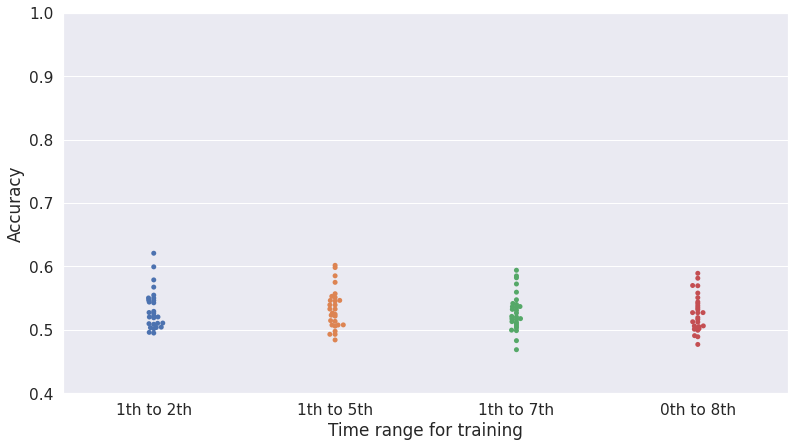

In [19]:
plt.figure(figsize=(13,7))

a=df_all_cat.groupby(['subject','csp_len']).mean('acc')
csp_len_column=[a.index.values[i][1] for i in range(len(a))]

sns.set(font_scale=1.4)
csp_len_column=np.where(np.array(csp_len_column)=='0 8','0th to 8th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 2','1th to 2th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 5','1th to 5th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 7','1th to 7th',csp_len_column)

#clusters_num_column=[a.index.values[i][2] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]

a['csp_len_column']=csp_len_column
#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='csp_len_column',y='acc',data=a, order=['1th to 2th','1th to 5th','1th to 7th','0th to 8th'])
ax.set(xlabel='Time range for training', ylabel='Accuracy')
ax.set(ylim=(0.4, 1))

plt.savefig('Figures/Reiamnn_Time_range_swarm.png', format='png', dpi=my_dpi)


In [24]:
v_v_v=np.unique(a['csp_len_column'].values)

In [25]:
v_v_v

array(['0th to 8th', '1th to 2th', '1th to 5th', '1th to 7th'],
      dtype=object)

In [26]:
s,p=kruskal(a[a['csp_len_column']==v_v_v[0]].acc.values, 
        a[a['csp_len_column']==v_v_v[1]].acc.values,
        a[a['csp_len_column']==v_v_v[2]].acc.values,
        a[a['csp_len_column']==v_v_v[3]].acc.values)

In [27]:
p=format(p, "5.2e")
s=np.round(s,3)
print(p)
print(s)

8.18e-01
0.93


In [70]:
means=df_all_cat.groupby(['time_category']).mean('acc')

## Bias

In [28]:
0.05
0.1
0.25
0.5


0.5

In [29]:
plt.figure(figsize=(13,7))
a=df_all_cat.groupby(['subject','bias']).mean('acc')
bias_column=[a.index.values[i][1] for i in range(len(a))]


<Figure size 936x504 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


NameError: name 'my_dpi' is not defined

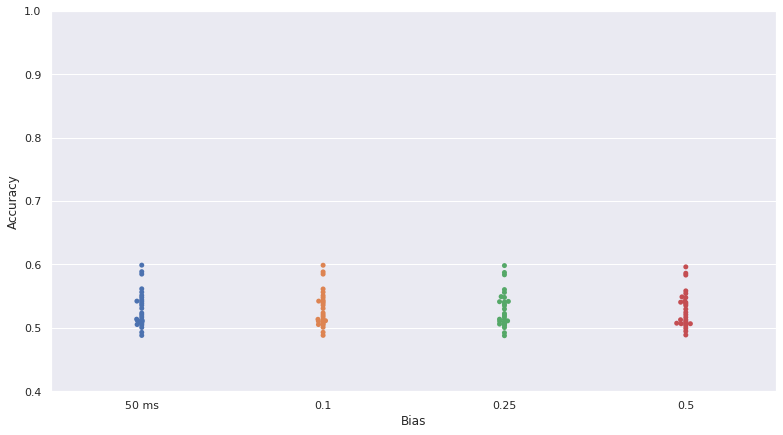

In [30]:
plt.figure(figsize=(13,7))
a=df_all_cat.groupby(['subject','bias']).mean('acc')
bias_column=[a.index.values[i][1] for i in range(len(a))]


bias_column=np.where(np.array(bias_column)==0.05,'50 ms',bias_column)
bias_column=np.where(np.array(bias_column)==0.1,'100 ms',bias_column)
bias_column=np.where(np.array(bias_column)==0.25,'500 ms',bias_column)
bias_column=np.where(np.array(bias_column)==0.5,'500 ms',bias_column)
#clusters_num_column=[a.index.values[i][2] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]

a['bias_column']=bias_column
#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
#sns.set_theme()
ax=swarmplot(x='bias_column',y='acc',data=a)

ax.set(xlabel='Bias', ylabel='Accuracy')
ax.set(ylim=(0.4, 1))

plt.savefig('Figures/Riemann_Bias_swarm.png', format='png', dpi=my_dpi)


In [31]:
v_v_v=np.unique(a['bias_column'].values)

In [32]:
v_v_v

array(['0.1', '0.25', '0.5', '50 ms'], dtype=object)

In [36]:
s,p=kruskal(a[a['bias_column']==v_v_v[0]].acc.values, 
        a[a['bias_column']==v_v_v[1]].acc.values,
        a[a['bias_column']==v_v_v[2]].acc.values,
        a[a['bias_column']==v_v_v[3]].acc.values)

In [37]:
p=format(p, "5.2e")
s=np.round(s,3)
print(p)
print(s)

9.91e-01
0.107


In [77]:
means=df_all_cat.groupby(['time_category']).mean('acc')

## Window size

In [38]:
plt.figure(figsize=(13,7))

a=df_all_cat.groupby(['subject','window']).mean('acc')
window_column=[a.index.values[i][1] for i in range(len(a))]


<Figure size 936x504 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


NameError: name 'my_dpi' is not defined

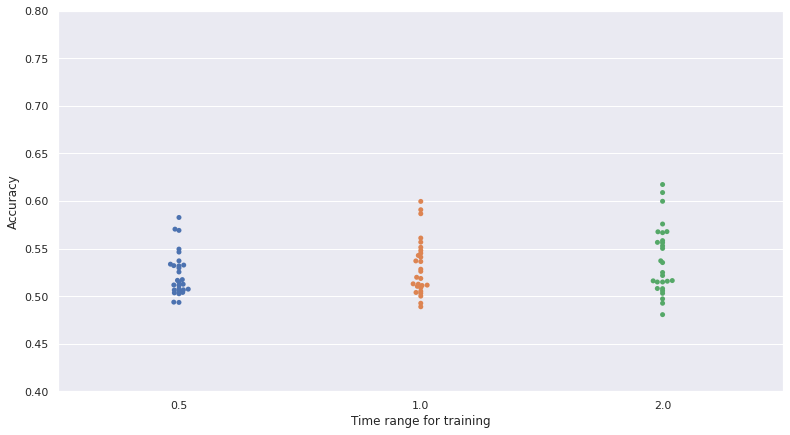

In [39]:
plt.figure(figsize=(13,7))

a=df_all_cat.groupby(['subject','window']).mean('acc')
window_column=[a.index.values[i][1] for i in range(len(a))]


csp_len_column=np.where(np.array(csp_len_column)==0.5,'500ms',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)==1,'1s',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)==2,'2s',csp_len_column)


a['window_column']=window_column
#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='window_column',y='acc',data=a)

ax.set(xlabel='Time range for training', ylabel='Accuracy')
ax.set(ylim=(0.4, 0.8))

plt.savefig('Figures/Riemann_Window_swarm.png', format='png', dpi=my_dpi)




In [40]:
v_v_v=np.unique(a['window_column'].values)

In [41]:
s,p=kruskal(a[a['window_column']==v_v_v[0]].acc.values, 
        a[a['window_column']==v_v_v[1]].acc.values,
        a[a['window_column']==v_v_v[2]].acc.values)

In [42]:
p=format(p, "5.2e")
s=np.round(s,3)
print(p)
print(s)

2.64e-01
2.666


In [83]:
means=df_all_cat.groupby(['window']).mean('acc')
means

,time,bias,acc
window,,,
0.5,4.0,0.112774,0.523436
1.0,4.0,0.112891,0.530392
2.0,4.0,0.113182,0.538227


In [84]:
v_v_v=np.unique(a['window_column'].values)
for i in range(len(v_v_v)):
    for j in range(len(v_v_v)):
        if i<j:
            
            s,p=mannwhitneyu(a[a['window_column']==v_v_v[i]].acc.values,
                     a[a['window_column']==v_v_v[j]].acc.values)
            
            
            p=format(p, "5.2e")
            acc_dif=np.round(means[means.index==v_v_v[i]].acc.values[0]-means[means.index==v_v_v[j]].acc.values[0],3)
            print(str(v_v_v[i])+'\t'+str(v_v_v[j])+'\t'+str(s)+'\t'+str(p)+'\t'+str(acc_dif))
            
            #print)

0.5	1.0	341.0	2.04e-01	-0.007
0.5	2.0	295.0	5.69e-02	-0.015
1.0	2.0	339.0	1.95e-01	-0.008


In [85]:
p

'1.95e-01'

## Time_catgory

In [45]:
sns.set()

In [47]:
df_all_cat

,time,window,bias,tasks,csp_len,subject,acc
0,0.25,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
1,0.30,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
2,0.35,0.5,0.05,"[3, 7, 11]",1 2,1,0.7
3,0.40,0.5,0.05,"[3, 7, 11]",1 2,1,0.5
4,0.45,0.5,0.05,"[3, 7, 11]",1 2,1,0.6
...,...,...,...,...,...,...,...
239995,5.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.8
239996,5.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7
239997,6.00,2.0,0.50,"[6, 10, 14]",0 8,34,0.7
239998,6.50,2.0,0.50,"[6, 10, 14]",0 8,34,0.7


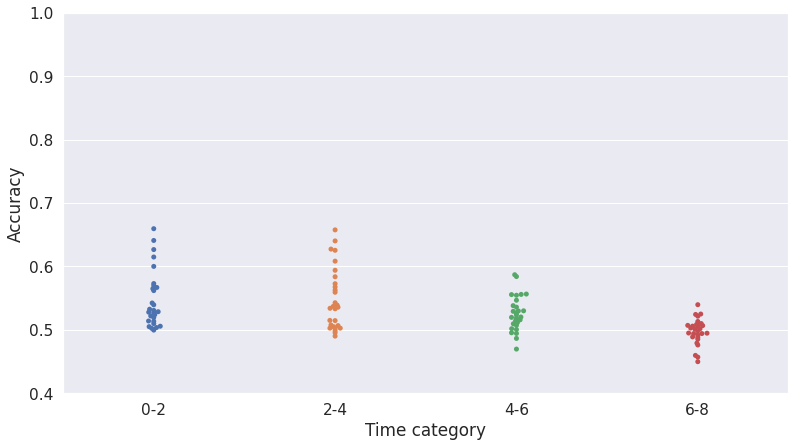

In [20]:
plt.figure(figsize=(13,7))
a=df_all_cat.groupby(['subject','time_category']).mean('acc')
time_category_column=[a.index.values[i][1] for i in range(len(a))]
#clusters_num_column=[a.index.values[i][2] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]

a['time_category_column']=time_category_column
#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='time_category_column',y='acc',data=a)


ax.set(xlabel='Time category', ylabel='Accuracy')
ax.set(ylim=(0.4, 1))
sns.set(font_scale=1.4)
my_dpi=150

plt.savefig('Figures/Riemann_Time_category_swarm.png', format='png', dpi=my_dpi)


In [57]:
s,p=friedmanchisquare(a[a['time_category_column']=='0-2'].acc.values, 
                            a[a['time_category_column']=='2-4'].acc.values,
                            a[a['time_category_column']=='4-6'].acc.values,
                            a[a['time_category_column']=='6-8'].acc.values)

In [53]:
means=df_all_cat.groupby(['time_category']).mean('acc')

In [58]:
p=format(p, "5.2e")
s=np.round(s,3)
print(p)
print(s)

1.17e-06
30.343


In [55]:
v_v_v=np.unique(a['time_category_column'].values)
for i in range(len(v_v_v)):
    for j in range(len(v_v_v)):
        if i<j:
            
            s,p=wilcoxon(a[a['time_category_column']==v_v_v[i]].acc.values,
                     a[a['time_category_column']==v_v_v[j]].acc.values)
            
            
            p=format(p, "5.2e")
            acc_dif=np.round(means[means.index==v_v_v[i]].acc.values[0]-means[means.index==v_v_v[j]].acc.values[0],3)
            print(v_v_v[i]+'\t'+v_v_v[j]+'\t'+str(s)+'\t'+str(p)+'\t'+str(acc_dif))
            
            #print)

0-2	2-4	186.0	6.99e-01	-0.001
0-2	4-6	69.0	2.28e-03	0.022
0-2	6-8	13.0	1.51e-05	0.05
2-4	4-6	72.0	2.85e-03	0.023
2-4	6-8	38.0	1.72e-04	0.051
4-6	6-8	27.0	6.13e-05	0.028


In [66]:
all_p_values=[
2.01e-03,
7.48e-03,
3.37e-04,
3.68e-01,
2.86e-01,
1.27e-01,
6.99e-01,
2.28e-03,
1.51e-05,
2.85e-03,
1.72e-04,
6.13e-05
]

In [67]:
import statsmodels
aaa=statsmodels.stats.multitest.multipletests(all_p_values,method='fdr_bh')
[print(str(format(aaa[1][i],"5.2e"))+'\t'+str(aaa[0][i])) for i in range(len(aaa[0]))]

4.56e-03	True
1.12e-02	True
1.01e-03	True
4.01e-01	False
3.43e-01	False
1.69e-01	False
6.99e-01	False
4.56e-03	True
1.81e-04	True
4.89e-03	True
6.88e-04	True
3.68e-04	True


[None, None, None, None, None, None, None, None, None, None, None, None]

## Time category and csp_len

In [92]:
a=df_all_cat.groupby(['subject','csp_len','time_category']).mean('acc')
a

time    window      bias       acc
subject csp_len time_category                                        
1       0 8     0-2            1.379474  1.052632  0.116316  0.565066
                2-4            3.166842  1.173684  0.112105  0.585428
                4-6            4.916489  1.159574  0.110106  0.560439
                6-8            6.658791  1.054945  0.113187  0.489904
        1 2     0-2            1.379474  1.052632  0.116316  0.593684
...                                 ...       ...       ...       ...
34      1 5     6-8            6.658791  1.054945  0.113187  0.483242
        1 7     0-2            1.379474  1.052632  0.116316  0.619211
                2-4            3.166842  1.173684  0.112105  0.600132
                4-6            4.916489  1.159574  0.110106  0.593318
                6-8            6.658791  1.054945  0.113187  0.513221

[448 rows x 4 columns]

In [93]:
a

time    window      bias       acc
subject csp_len time_category                                        
1       0 8     0-2            1.379474  1.052632  0.116316  0.565066
                2-4            3.166842  1.173684  0.112105  0.585428
                4-6            4.916489  1.159574  0.110106  0.560439
                6-8            6.658791  1.054945  0.113187  0.489904
        1 2     0-2            1.379474  1.052632  0.116316  0.593684
...                                 ...       ...       ...       ...
34      1 5     6-8            6.658791  1.054945  0.113187  0.483242
        1 7     0-2            1.379474  1.052632  0.116316  0.619211
                2-4            3.166842  1.173684  0.112105  0.600132
                4-6            4.916489  1.159574  0.110106  0.593318
                6-8            6.658791  1.054945  0.113187  0.513221

[448 rows x 4 columns]

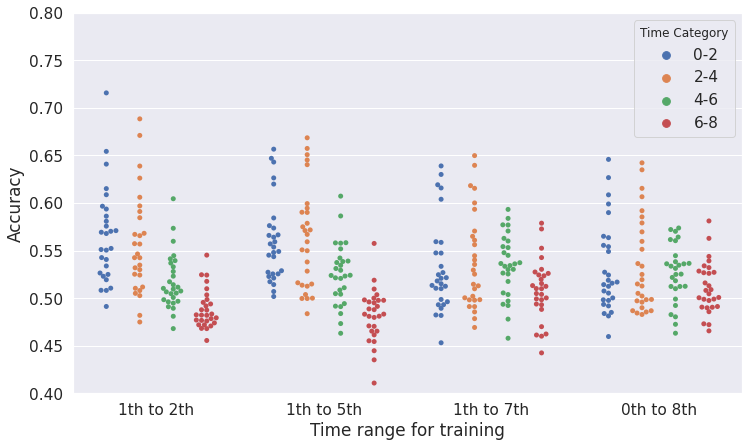

In [21]:
plt.figure(figsize=(12,7))
a=df_all_cat.groupby(['subject','csp_len','time_category']).mean('acc')
time_category_column=[a.index.values[i][2] for i in range(len(a))]
csp_len_column=[a.index.values[i][1] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]


csp_len_column=np.where(np.array(csp_len_column)=='0 8','0th to 8th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 2','1th to 2th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 5','1th to 5th',csp_len_column)
csp_len_column=np.where(np.array(csp_len_column)=='1 7','1th to 7th',csp_len_column)


a['Time Category']=time_category_column
a['time_category_column/csp_len']=[time_category_column[i] +'/'+ csp_len_column[i] for i in range(len(time_category_column))]
a['csp_len']=csp_len_column

#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='csp_len',y='acc',hue='Time Category',data=a, order=['1th to 2th','1th to 5th','1th to 7th','0th to 8th'], dodge=True)
#swarmplot(x='time_category_column/csp_len',y='acc',data=a)

sns.set(font_scale=1.4)

ax.set(xlabel='Time range for training', ylabel='Accuracy')
ax.set(ylim=(0.4, 0.8))

my_dpi=150

plt.savefig('Figures/Riemann_Time_category_Train_range_swarm.png', format='png', dpi=my_dpi)


In [95]:
a[a['time_category_column']=='0-2'].head(50)

time    window      bias       acc  \
subject csp_len time_category                                           
1       0 8     0-2            1.379474  1.052632  0.116316  0.622500   
        1 2     0-2            1.379474  1.052632  0.116316  0.590658   
        1 5     0-2            1.379474  1.052632  0.116316  0.567895   
        1 7     0-2            1.379474  1.052632  0.116316  0.640000   
2       0 8     0-2            1.379474  1.052632  0.116316  0.605000   
        1 2     0-2            1.379474  1.052632  0.116316  0.703947   
        1 5     0-2            1.379474  1.052632  0.116316  0.629737   
        1 7     0-2            1.379474  1.052632  0.116316  0.612368   
3       0 8     0-2            1.379474  1.052632  0.116316  0.465395   
        1 2     0-2            1.379474  1.052632  0.116316  0.481447   
        1 5     0-2            1.379474  1.052632  0.116316  0.482368   
        1 7     0-2            1.379474  1.052632  0.116316  0.509474   
4       0 8     0-2            1.379474  1.052632  0.116316  0.550789   
        1 2     0-2            1.379474  1.052632  0.116316  0.626447   
        1 5     0-2            1.379474  1.052632  0.116316  0.589342   
        1 7     0-2            1.379474  1.052632  0.116316  0.567368   
5       0 8     0-2            1.379474  1.052632  0.116316  0.546711   
        1 2     0-2            1.379474  1.052632  0.116316  0.576184   
        1 5     0-2            1.379474  1.052632  0.116316  0.566053   
        1 7     0-2            1.379474  1.052632  0.116316  0.540132   
6       0 8     0-2            1.379474  1.052632  0.116316  0.509605   
        1 2     0-2            1.379474  1.052632  0.116316  0.529342   
        1 5     0-2            1.379474  1.052632  0.116316  0.515658   
        1 7     0-2            1.379474  1.052632  0.116316  0.514079   
7       0 8     0-2            1.379474  1.052632  0.116316  0.601053   
        1 2     0-2            1.379474  1.052632  0.116316  0.633553   
        1 5     0-2            1.379474  1.052632  0.116316  0.584211   
        1 7     0-2            1.379474  1.052632  0.116316  0.587368   
8       0 8     0-2            1.379474  1.052632  0.116316  0.651447   
        1 2     0-2            1.379474  1.052632  0.116316  0.674605   
        1 5     0-2            1.379474  1.052632  0.116316  0.669342   
        1 7     0-2            1.379474  1.052632  0.116316  0.676184   
9       0 8     0-2            1.379474  1.052632  0.116316  0.497763   
        1 2     0-2            1.379474  1.052632  0.116316  0.518684   
        1 5     0-2            1.379474  1.052632  0.116316  0.543026   
        1 7     0-2            1.379474  1.052632  0.116316  0.517237   
15      0 8     0-2            1.379474  1.052632  0.116316  0.679211   
        1 2     0-2            1.379474  1.052632  0.116316  0.678421   
        1 5     0-2            1.379474  1.052632  0.116316  0.677237   
        1 7     0-2            1.379474  1.052632  0.116316  0.661842   
16      0 8     0-2            1.379474  1.052632  0.116316  0.541184   
        1 2     0-2            1.379474  1.052632  0.116316  0.503158   
        1 5     0-2            1.379474  1.052632  0.116316  0.536447   
        1 7     0-2            1.379474  1.052632  0.116316  0.508684   
17      0 8     0-2            1.379474  1.052632  0.116316  0.501974   
        1 2     0-2            1.379474  1.052632  0.116316  0.520263   
        1 5     0-2            1.379474  1.052632  0.116316  0.505395   
        1 7     0-2            1.379474  1.052632  0.116316  0.496316   
18      0 8     0-2            1.379474  1.052632  0.116316  0.471579   
        1 2     0-2            1.379474  1.052632  0.116316  0.496053   

                              time_category_column csp_len  
subject csp_len time_category                               
1       0 8     0-2                            0-2     0 8  
        1 2     0-2                            0-2     

In [ ]:
Window
Bias
Time range for training
Task

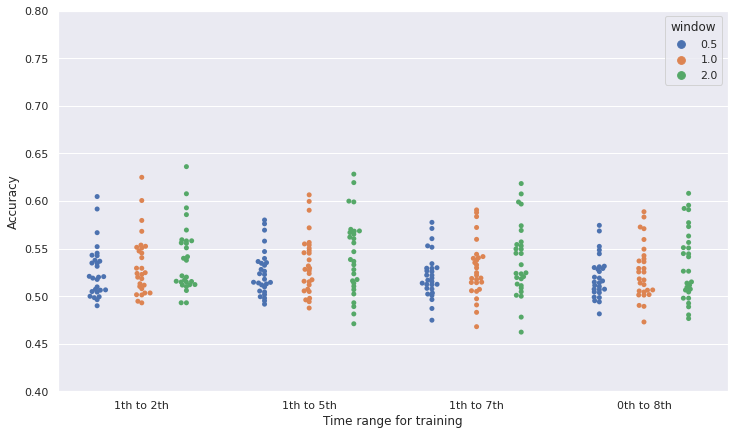

In [151]:
plt.figure(figsize=(12,7))
a=df_all_cat.groupby(['subject','csp_len','window']).mean('acc')
time_category_column=[a.index.values[i][2] for i in range(len(a))]
window_column=[a.index.values[i][1] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]


#csp_len_column=np.where(np.array(csp_len_column)=='0 8','0th to 8th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 2','1th to 2th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 5','1th to 5th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 7','1th to 7th',csp_len_column)


a['window']=time_category_column
a['window/csp_len']=[window_column[i] +'/'+ csp_len_column[i] for i in range(len(window_column))]
a['csp_len']=csp_len_column

#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='csp_len',y='acc',hue='window',data=a, order=['1th to 2th','1th to 5th','1th to 7th','0th to 8th'], dodge=True)
#swarmplot(x='time_category_column/csp_len',y='acc',data=a)



ax.set(xlabel='Time range for training', ylabel='Accuracy')
ax.set(ylim=(0.4, 0.8))

my_dpi=150

#plt.savefig('Figures/Riemann_Time_category_Train_range_swarm.png', format='png', dpi=my_dpi)


In [ ]:
plt.figure(figsize=(12,7))
a=df_all_cat.groupby(['subject','csp_len','window']).mean('acc')
time_category_column=[a.index.values[i][2] for i in range(len(a))]
window_column=[a.index.values[i][1] for i in range(len(a))]
#atlasses_num_column=[a.index.values[i][3] for i in range(len(a))]
#lambdas_num_column=[a.index.values[i][4] for i in range(len(a))]


#csp_len_column=np.where(np.array(csp_len_column)=='0 8','0th to 8th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 2','1th to 2th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 5','1th to 5th',csp_len_column)
#csp_len_column=np.where(np.array(csp_len_column)=='1 7','1th to 7th',csp_len_column)


a['window']=time_category_column
a['window/csp_len']=[window_column[i] +'/'+ csp_len_column[i] for i in range(len(window_column))]
a['csp_len']=csp_len_column

#a['clusters_num_column']=clusters_num_column
#a['atlasses_num_column']=atlasses_num_column
#a['lambdas_num_column']=lambdas_num_column

#a_=a[a['tasks_column']=='[4, 8, 12]']
ax=swarmplot(x='csp_len',y='acc',hue='window',data=a, order=['1th to 2th','1th to 5th','1th to 7th','0th to 8th'], dodge=True)
#swarmplot(x='time_category_column/csp_len',y='acc',data=a)



ax.set(xlabel='Time range for training', ylabel='Accuracy')
ax.set(ylim=(0.4, 0.8))

my_dpi=150

#plt.savefig('Figures/Riemann_Time_category_Train_range_swarm.png', format='png', dpi=my_dpi)


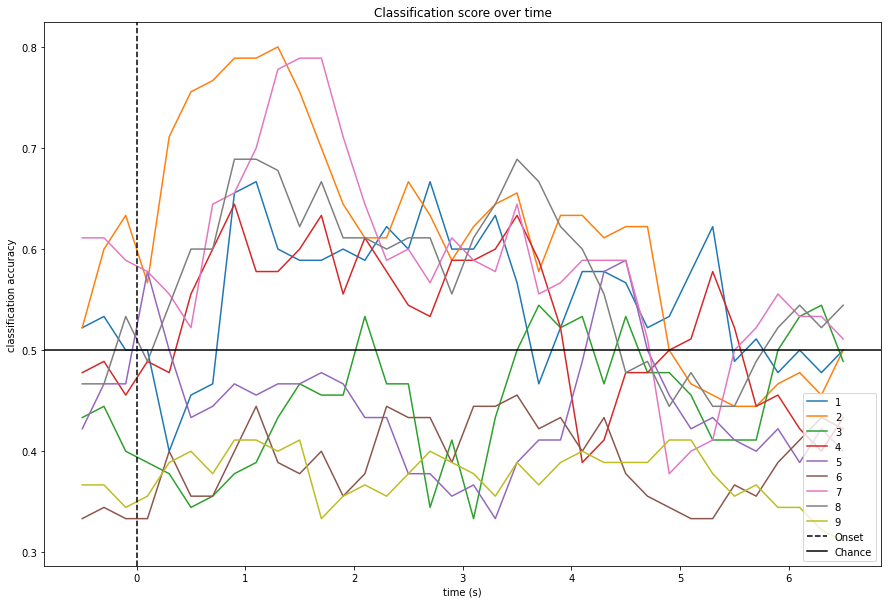

In [35]:
plt.figure(figsize=(15,10))
for i in range(1,10):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(w_times,np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()

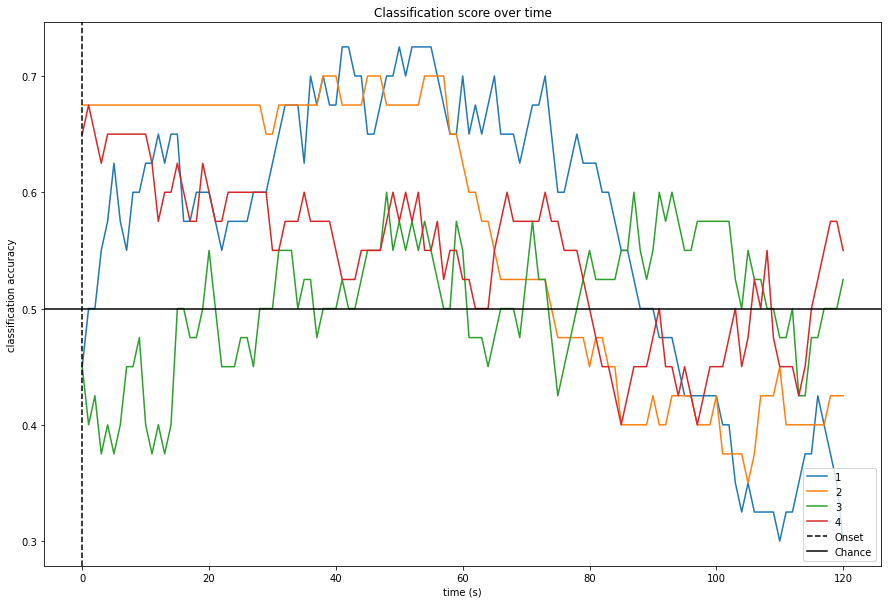

In [75]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()

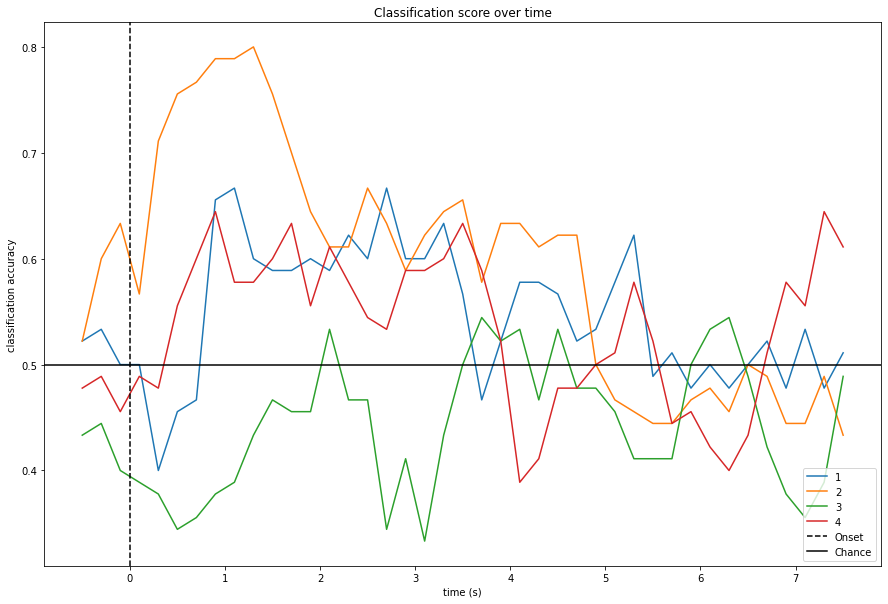

In [59]:
plt.figure(figsize=(15,10))
for i in range(1,5):
    
    scores_windows=np.load('Riemann_results/Riemann_results'+str(i)+'.npy')
    

    plt.plot(w_times,np.mean(scores_windows, 0), label=i)
    
    
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')

plt.show()